In [1]:
# Reading Files
import os
import pandas as pd
import logging

logging.basicConfig(filename='debug.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
def extract_labels(image_filename):
    try:
        basename = os.path.basename(image_filename)
        name, _ = os.path.splitext(basename)
        labels = name.split('_')
        return {
            'age': int(labels[0]),
            'gender': int(labels[1]),
            'race': int(labels[2]),
            'datetime': labels[3]
        }
    except Exception as e:
        logging.error(f"Error extracting labels from {image_filename}: {e}")
        return None

def process_image_folder(folder_path):
    
    data = []
    for subdir, _, files in os.walk(folder_path):
        logging.info(f"Processing directory: {subdir}")
        for file in files:
            if file.endswith(".jpg"):
                file_path = os.path.join(subdir, file)
                logging.info(f"Found image file: {file_path}")
                labels = extract_labels(file_path)
                if labels:
                    labels['image_path'] = file_path
                    data.append(labels)
                    logging.info(f"Extracted labels: {labels}")
                else:
                    logging.warning(f"Skipping file due to label extraction error: {file_path}")
            else:
                logging.warning(f"Skipping non-image file: {file}")

    if data:
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame(columns=['age', 'gender', 'race', 'datetime', 'image_path'])
    return df

main_folder = "data" 
dataframe = process_image_folder(main_folder)

output_csv = 'demographic_features.csv'
dataframe.to_csv(output_csv, index=False)
print(f"Data has been processed and saved to {output_csv}")

Data has been processed and saved to demographic_features.csv


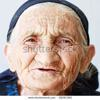

Age: 100, Gender: 1, Race: 0, DateTime: 20170110183726390


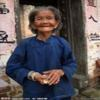

Age: 100, Gender: 1, Race: 2, DateTime: 20170105174847679


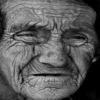

Age: 100, Gender: 1, Race: 2, DateTime: 20170110182836729


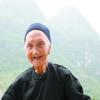

Age: 101, Gender: 1, Race: 2, DateTime: 20170105174739309


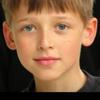

Age: 10, Gender: 0, Race: 0, DateTime: 20161220222308131


In [2]:
from IPython.display import Image, display
import pandas as pd

# Loading the CSV file
input_csv = 'demographic_features.csv'
df = pd.read_csv(input_csv)

def display_images_with_dataframe(df):
    for i, row in df.iterrows():
        display(Image(filename=row['image_path'], width=30, height=30))
        print(f"Age: {row['age']}, Gender: {row['gender']}, Race: {row['race']}, DateTime: {row['datetime']}")

display_images_with_dataframe(df.head())


In [3]:
df.head()

,age,gender,race,datetime,image_path
0,100,1,0,20170110183726390,data\part1\100_1_0_20170110183726390.jpg
1,100,1,2,20170105174847679,data\part1\100_1_2_20170105174847679.jpg
2,100,1,2,20170110182836729,data\part1\100_1_2_20170110182836729.jpg
3,101,1,2,20170105174739309,data\part1\101_1_2_20170105174739309.jpg
4,10,0,0,20161220222308131,data\part1\10_0_0_20161220222308131.jpg


In [4]:
df.shape

(24102, 5)

In [5]:
df.isnull().sum()

age           0
gender        0
race          0
datetime      0
image_path    0
dtype: int64

## Data Analysis

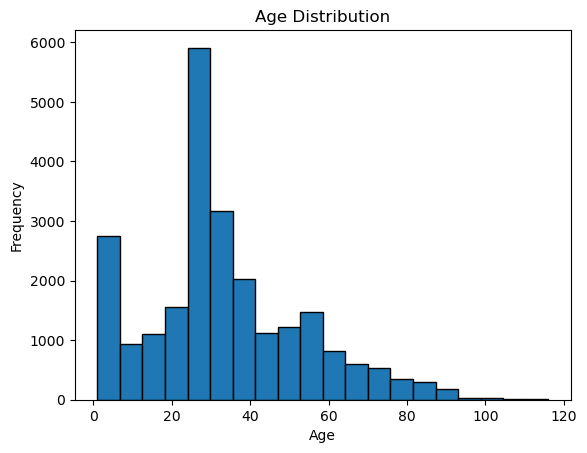

In [35]:
# Ploting age distribution
import matplotlib.pyplot as plt
plt.hist(df['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

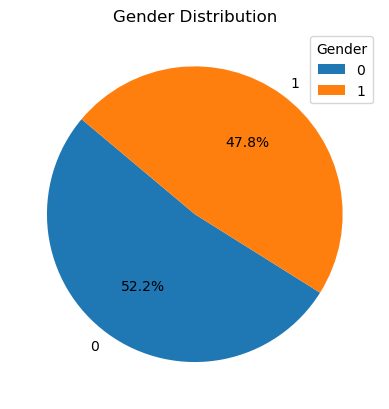

In [36]:
# Ploting Gender distribution
gender_counts = df['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.legend(title='Gender')
plt.show()


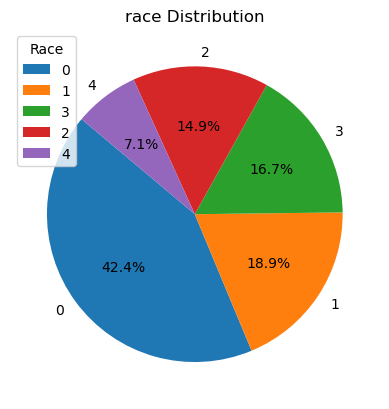

In [23]:
# Ploting Race Destribution
gender_counts = df['race'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('race Distribution')
plt.legend(title='Race')
plt.show()

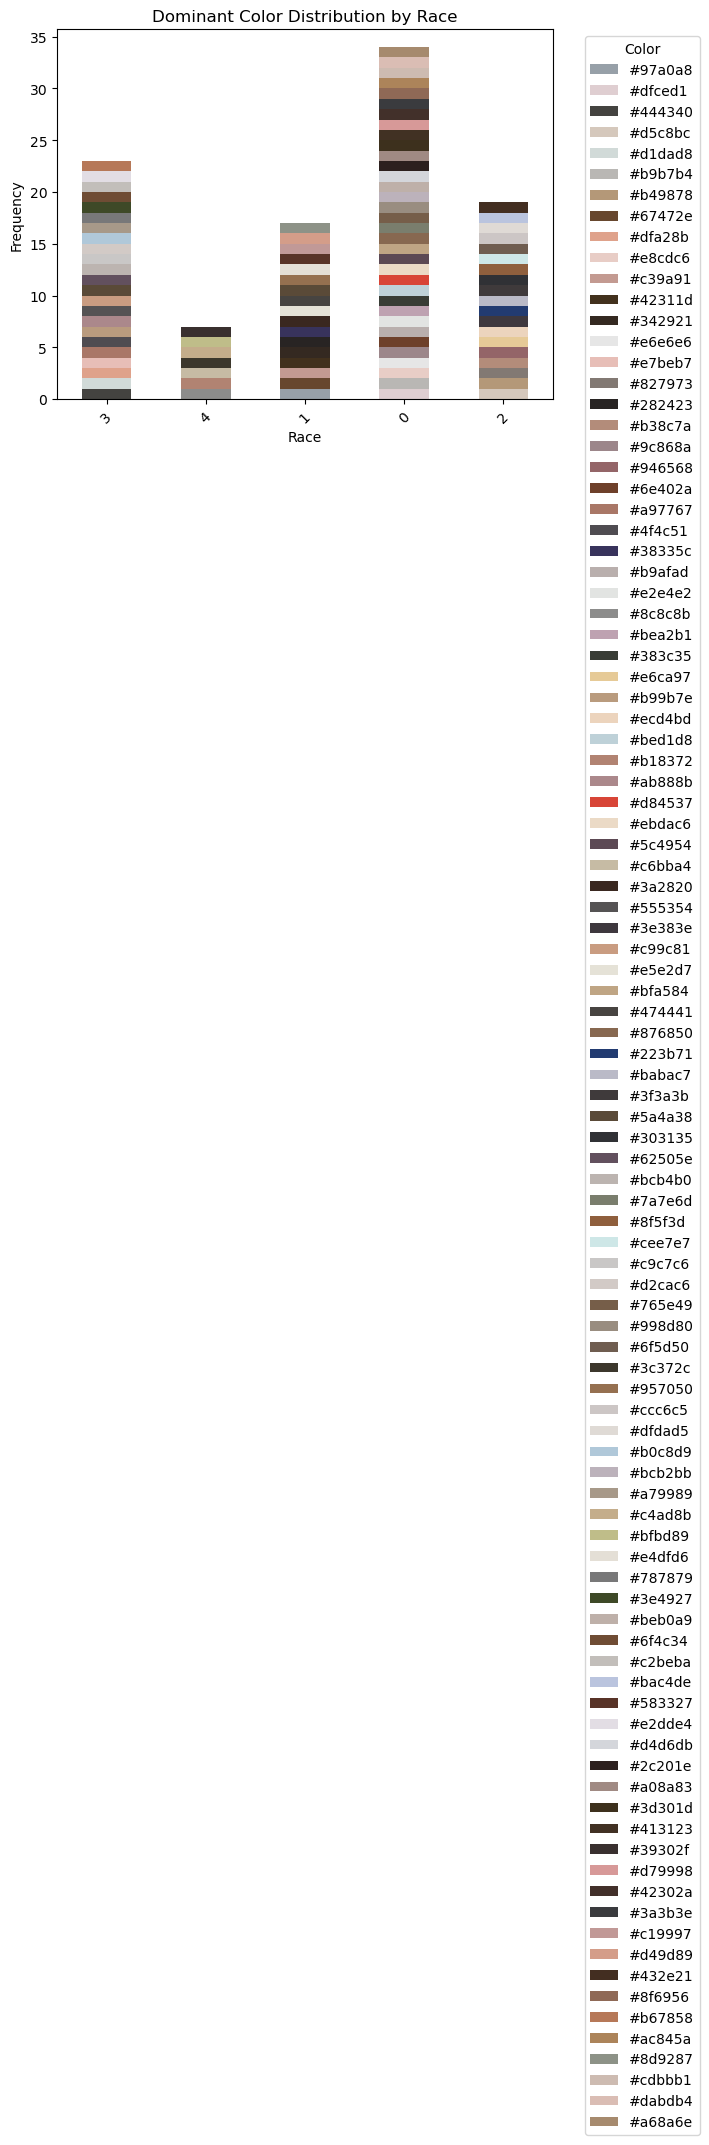

In [37]:
# Ploting Colors of Images
from colorthief import ColorThief
from PIL import Image
import concurrent.futures
from collections import Counter

# Function to get the dominant color
def get_dominant_color(image_path):
    try:
        color_thief = ColorThief(image_path)
        dominant_color = color_thief.get_color(quality=1)
        return dominant_color
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return (0, 0, 0) 
        
sampled_df = df.sample(100)
def process_images(df):
    dominant_colors = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(get_dominant_color, row['image_path']) for idx, row in df.iterrows()]
        for future in concurrent.futures.as_completed(futures):
            dominant_colors.append(future.result())
    return dominant_colors
    
sampled_df.loc[:, 'dominant_color'] = process_images(sampled_df)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

sampled_df.loc[:, 'dominant_color_hex'] = sampled_df['dominant_color'].apply(rgb_to_hex)

races = sampled_df['race'].unique()
color_data = {}

for race in races:
    race_df = sampled_df[sampled_df['race'] == race]
    color_counts = Counter(race_df['dominant_color_hex'])
    color_data[race] = color_counts

colors = list(set(sampled_df['dominant_color_hex']))
data = {color: [color_data[race].get(color, 0) for race in races] for color in colors}
color_df = pd.DataFrame(data, index=races)

color_df.plot(kind='bar', stacked=True, color=colors)
plt.title('Dominant Color Distribution by Race')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.legend(title='Color', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()